In [28]:
# =============================================================================
# 1. ENVIRONMENT SETUP
# =============================================================================
!pip install tensorflow pandas numpy matplotlib seaborn scikit-learn imbalanced-learn -q

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_recall_fscore_support
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import zipfile
import os
import warnings

warnings.filterwarnings('ignore')
np.random.seed(42)
tf.random.set_seed(42)

plt.style.use('seaborn-v0_8-whitegrid')
print(f"TensorFlow Version: {tf.__version__}")
print("Environment ready.\n")

TensorFlow Version: 2.19.0
Environment ready.



In [29]:
# =============================================================================
# 2. CONFIGURATION
# =============================================================================
CONFIG = {
    'test_size': 0.20,
    'val_size': 0.15,
    'random_state': 42,
    'epochs': 200,
    'batch_size': 32,
    'learning_rate': 0.001,
    'early_stop_patience': 25,
    'lr_reduce_patience': 10,
    'smote_k_neighbors': 3,
    'excluded_classes': ['cold_stress'],  # Classes to remove from dataset
    'features': ['N', 'P', 'K', 'pH', 'soil_moisture', 'temperature'],
    'target_column': 'stress_type',
    'model_filename': 'plant_health_model.tflite',
    'header_filename': 'plant_health_model.h',
    'package_filename': 'plant_health_model_package.zip'
}

In [30]:
# =============================================================================
# 3. DATA LOADING
# =============================================================================
from google.colab import files

print("=" * 70)
print("DATA LOADING")
print("=" * 70)
print("\nUpload your dataset (CSV format):")
df_raw = pd.read_csv("plant_health.csv")
print(f"\nDataset loaded: {df_raw.shape[0]:,} samples, {df_raw.shape[1]} columns")


DATA LOADING

Upload your dataset (CSV format):

Dataset loaded: 2,192 samples, 7 columns



DATA PREPROCESSING

Original class distribution:
stress_type
healthy                  742
nitrogen_deficiency      430
phosphorus_deficiency    327
potassium_deficiency     254
water_stress             136
ph_stress_alkaline       125
ph_stress_acidic         109
cold_stress               69

Removed classes: ['cold_stress']
Samples removed: 69
Final dataset: 2,123 samples

Final class distribution:
stress_type
healthy                  742
nitrogen_deficiency      430
phosphorus_deficiency    327
potassium_deficiency     254
water_stress             136
ph_stress_alkaline       125
ph_stress_acidic         109

Class imbalance ratio: 14.7%
Note: Dataset is imbalanced. SMOTE will be applied.


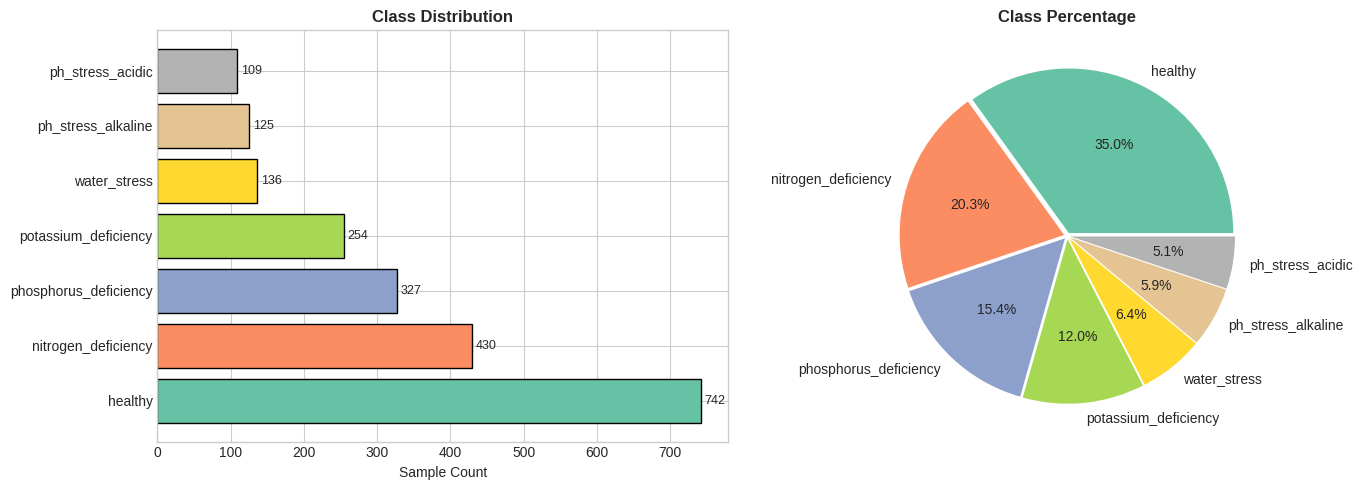

In [31]:
# =============================================================================
# 4. DATA PREPROCESSING
# =============================================================================
print("\n" + "=" * 70)
print("DATA PREPROCESSING")
print("=" * 70)

# Display original class distribution
print(f"\nOriginal class distribution:")
print(df_raw[CONFIG['target_column']].value_counts().to_string())

# Remove excluded classes
df = df_raw[~df_raw[CONFIG['target_column']].isin(CONFIG['excluded_classes'])].copy()
df = df.reset_index(drop=True)

removed_count = len(df_raw) - len(df)
if removed_count > 0:
    print(f"\nRemoved classes: {CONFIG['excluded_classes']}")
    print(f"Samples removed: {removed_count:,}")

print(f"Final dataset: {len(df):,} samples")

# Display final class distribution
print(f"\nFinal class distribution:")
class_dist = df[CONFIG['target_column']].value_counts()
print(class_dist.to_string())

# Class balance analysis
imbalance_ratio = class_dist.min() / class_dist.max()
print(f"\nClass imbalance ratio: {imbalance_ratio:.1%}")
if imbalance_ratio < 0.5:
    print("Note: Dataset is imbalanced. SMOTE will be applied.")

# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = plt.cm.Set2(np.linspace(0, 1, len(class_dist)))
axes[0].barh(class_dist.index, class_dist.values, color=colors, edgecolor='black')
axes[0].set_xlabel('Sample Count')
axes[0].set_title('Class Distribution', fontweight='bold', fontsize=12)
for i, (idx, val) in enumerate(class_dist.items()):
    axes[0].text(val + 5, i, f'{val:,}', va='center', fontsize=9)

axes[1].pie(class_dist.values, labels=class_dist.index, autopct='%1.1f%%',
            colors=colors, explode=[0.02]*len(class_dist))
axes[1].set_title('Class Percentage', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.savefig('01_class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()


EXPLORATORY DATA ANALYSIS

Dataset shape: (2123, 7)

Feature statistics:
             N        P        K       pH  soil_moisture  temperature
count  2123.00  2123.00  2123.00  2123.00        2123.00      2123.00
mean     50.01    52.75    46.83     6.47          45.32        25.25
std      37.08    32.39    48.98     0.78          26.05         5.84
min       0.00     5.00     5.00     3.50           1.00        13.89
25%      20.50    27.00    20.00     5.96          22.00        19.73
50%      37.00    51.00    31.00     6.42          45.00        25.21
75%      84.00    68.00    48.00     6.93          68.00        30.75
max     140.00   145.00   205.00     9.94          90.00        37.60

Missing values: 0


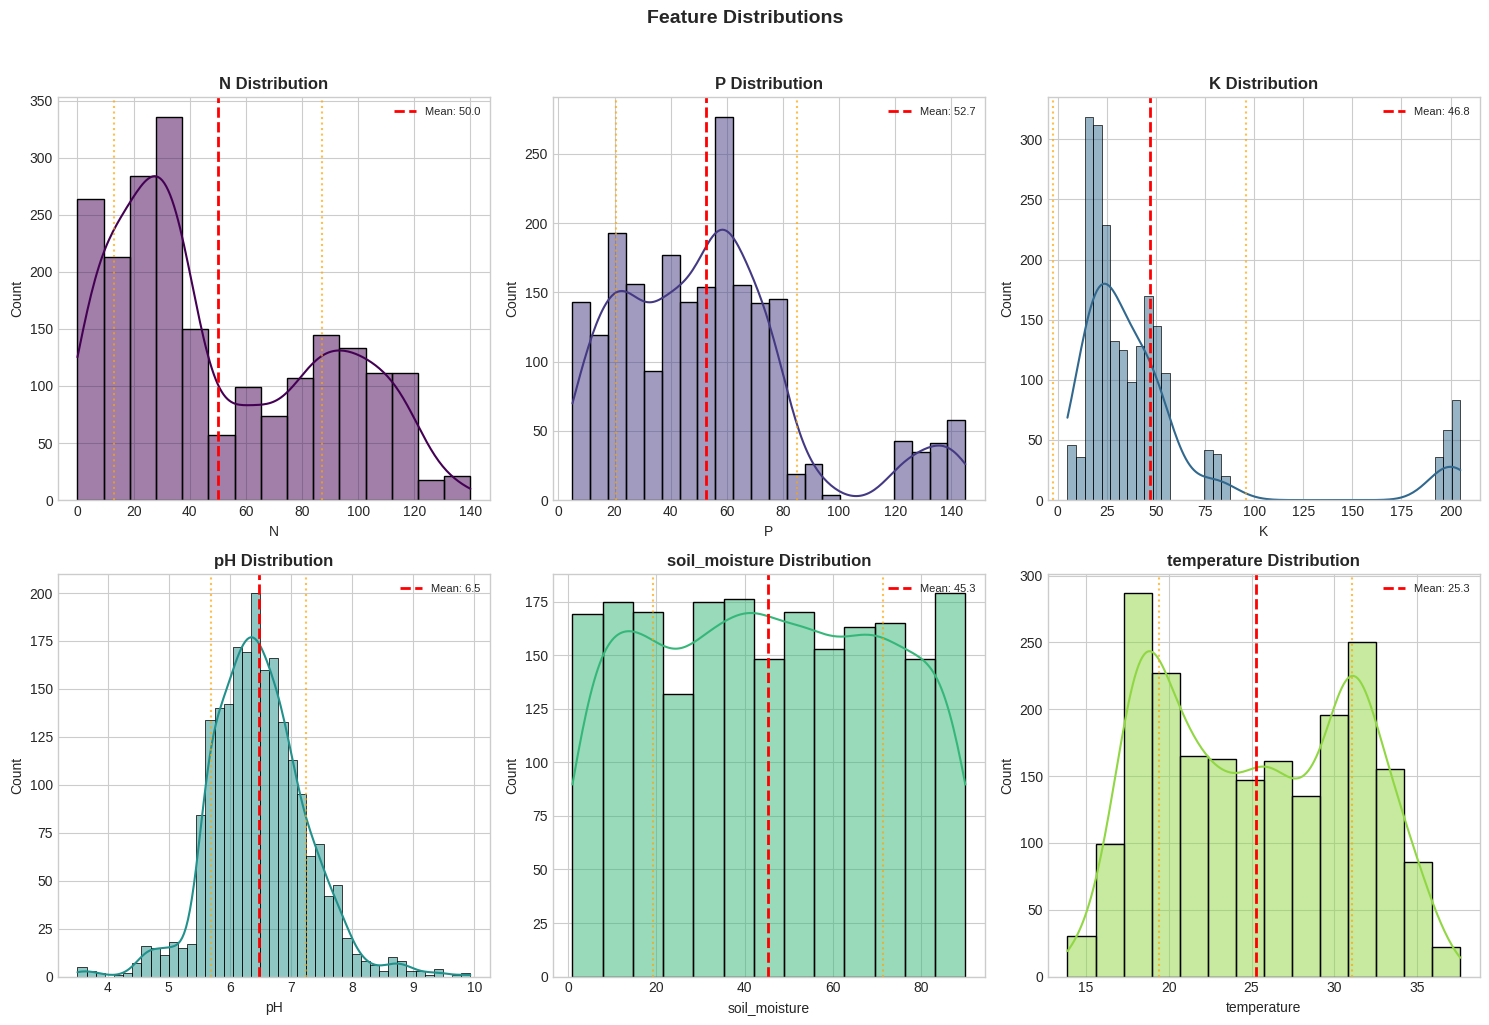

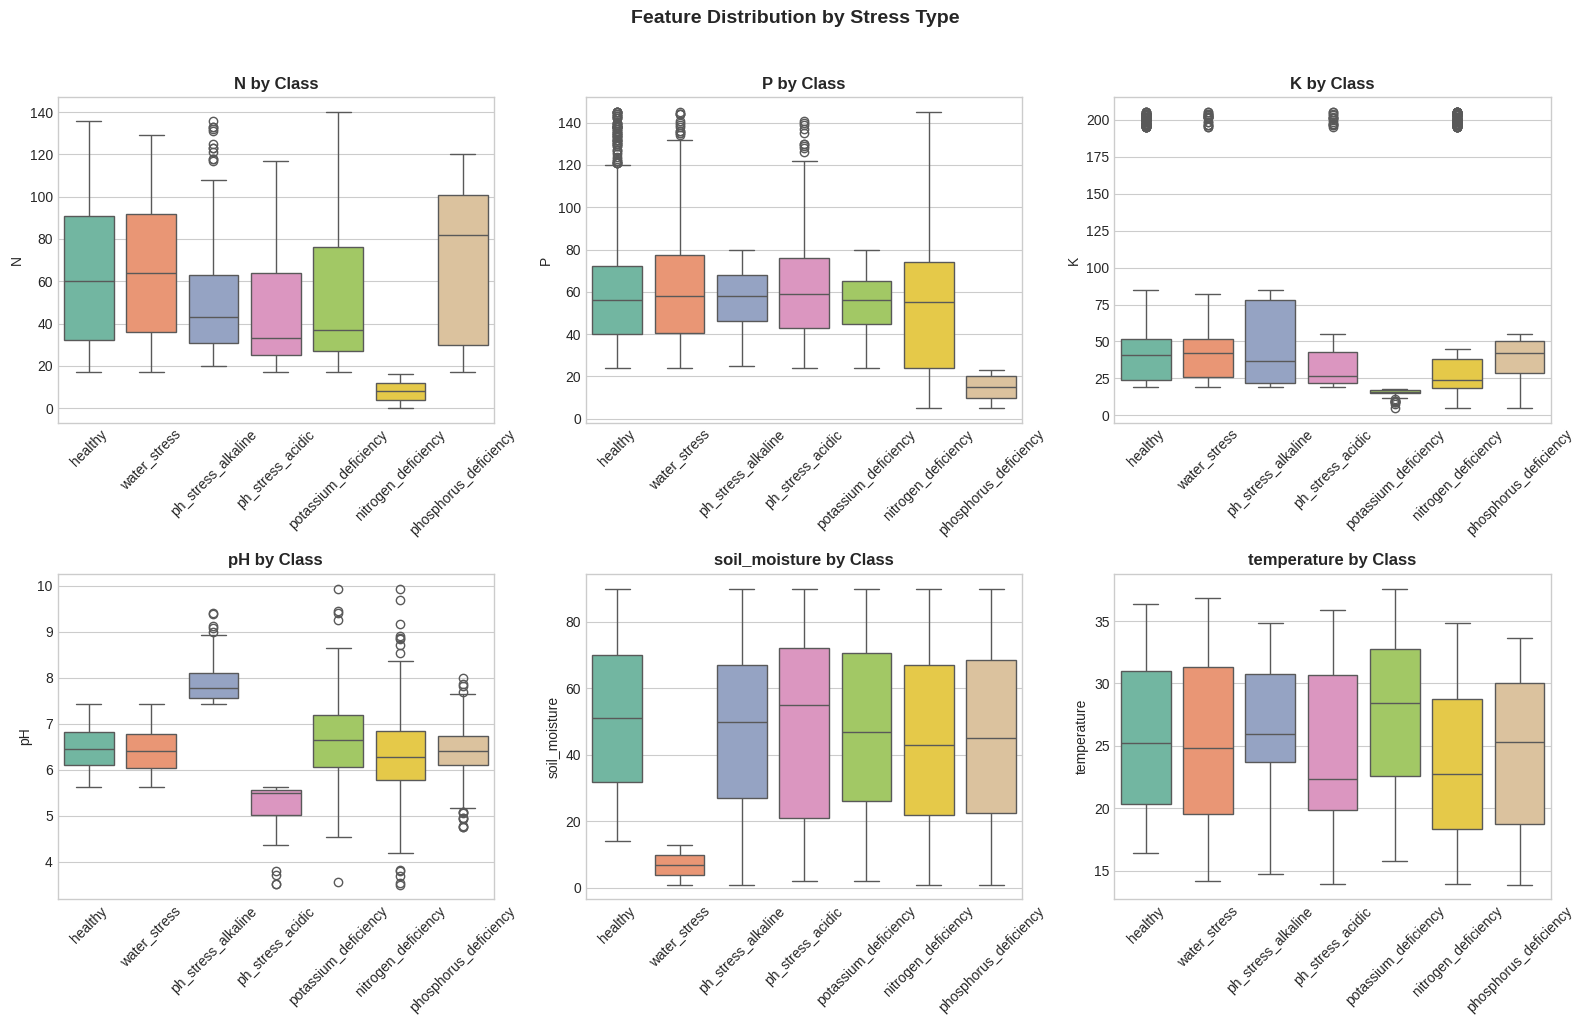

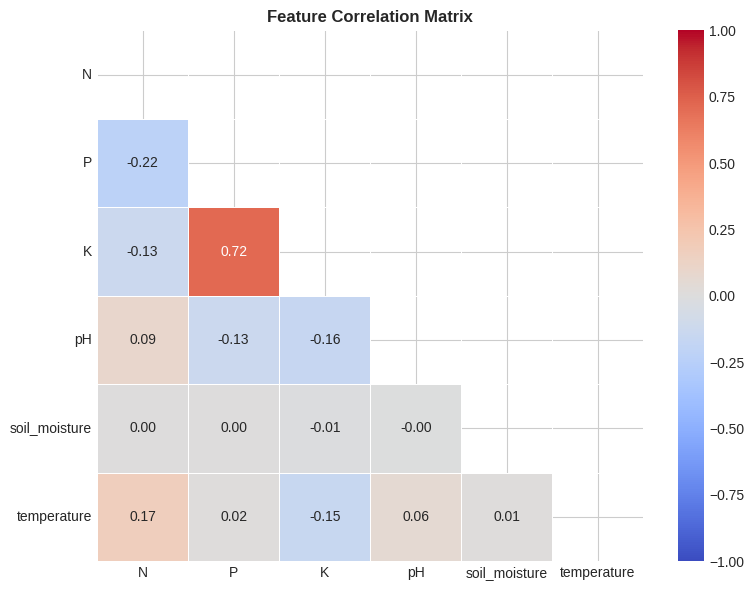

In [32]:
# =============================================================================
# 5. EXPLORATORY DATA ANALYSIS
# =============================================================================
print("\n" + "=" * 70)
print("EXPLORATORY DATA ANALYSIS")
print("=" * 70)

print(f"\nDataset shape: {df.shape}")
print(f"\nFeature statistics:")
print(df[CONFIG['features']].describe().round(2).to_string())

print(f"\nMissing values: {df.isnull().sum().sum()}")

# Feature distribution plots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, feature in enumerate(CONFIG['features']):
    ax = axes[idx]
    sns.histplot(data=df, x=feature, kde=True, ax=ax, color=plt.cm.viridis(idx/6))
    mean_val = df[feature].mean()
    std_val = df[feature].std()
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=2,
               label=f'Mean: {mean_val:.1f}')
    ax.axvline(mean_val - std_val, color='orange', linestyle=':', alpha=0.7)
    ax.axvline(mean_val + std_val, color='orange', linestyle=':', alpha=0.7)
    ax.set_title(f'{feature} Distribution', fontweight='bold')
    ax.legend(fontsize=8)

plt.suptitle('Feature Distributions', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('02_feature_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

# Feature distribution by class
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, feature in enumerate(CONFIG['features']):
    ax = axes[idx]
    sns.boxplot(data=df, x=CONFIG['target_column'], y=feature, ax=ax, palette='Set2')
    ax.set_title(f'{feature} by Class', fontweight='bold')
    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=45)

plt.suptitle('Feature Distribution by Stress Type', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('03_features_by_class.png', dpi=150, bbox_inches='tight')
plt.show()

# Correlation matrix
fig, ax = plt.subplots(figsize=(8, 6))
corr_matrix = df[CONFIG['features']].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            fmt='.2f', linewidths=0.5, ax=ax, vmin=-1, vmax=1)
ax.set_title('Feature Correlation Matrix', fontweight='bold', fontsize=12)
plt.tight_layout()
plt.savefig('04_correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()


DATA PREPARATION

Input features: 6
Output classes: 7

Class encoding:
  0 -> healthy
  1 -> nitrogen_deficiency
  2 -> ph_stress_acidic
  3 -> ph_stress_alkaline
  4 -> phosphorus_deficiency
  5 -> potassium_deficiency
  6 -> water_stress

Data split:
  Training:   1,443 samples (68.0%)
  Validation: 255 samples (12.0%)
  Test:       425 samples (20.0%)

Scaler parameters:
  Means: [50.7076, 51.8919, 45.0499,  6.4677, 45.6195, 25.445 ]
  Stds:  [37.3246, 31.4975, 46.5609,  0.7904, 26.087 ,  5.7967]

Applying SMOTE oversampling to training data...
  Before: 1,443 samples
  After:  3,528 samples


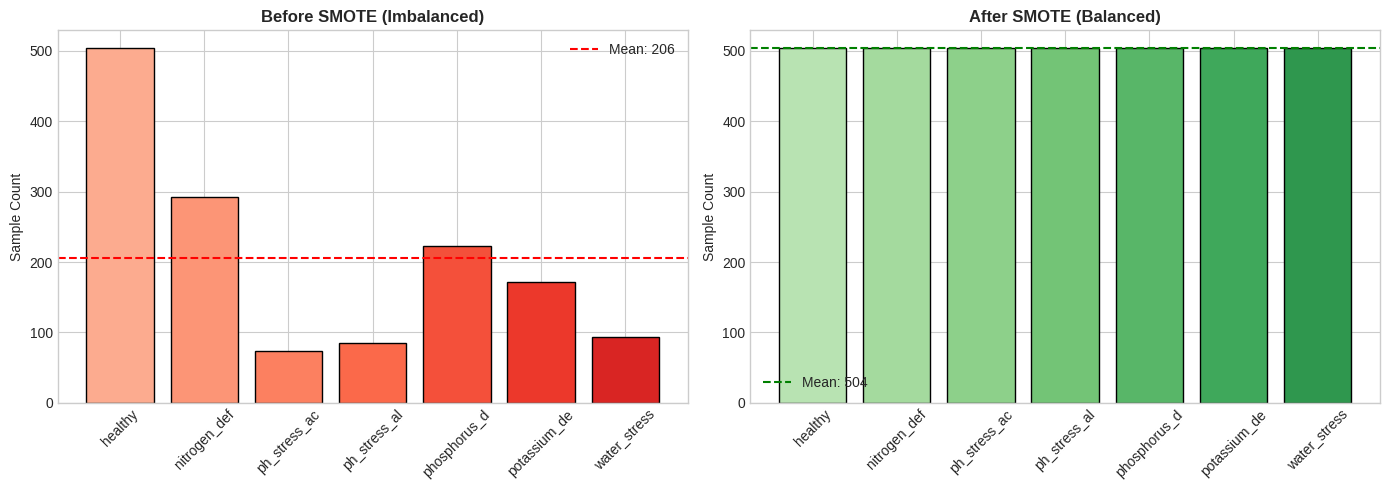

In [33]:
# =============================================================================
# 6. DATA PREPARATION
# =============================================================================
print("\n" + "=" * 70)
print("DATA PREPARATION")
print("=" * 70)

# Prepare features and target
X = df[CONFIG['features']].values
y = df[CONFIG['target_column']].values

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

n_classes = len(label_encoder.classes_)
n_features = len(CONFIG['features'])

print(f"\nInput features: {n_features}")
print(f"Output classes: {n_classes}")

print(f"\nClass encoding:")
for i, cls in enumerate(label_encoder.classes_):
    print(f"  {i} -> {cls}")

# Split data: Train / Validation / Test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_encoded,
    test_size=CONFIG['test_size'],
    random_state=CONFIG['random_state'],
    stratify=y_encoded
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=CONFIG['val_size'],
    random_state=CONFIG['random_state'],
    stratify=y_temp
)

print(f"\nData split:")
print(f"  Training:   {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Validation: {len(X_val):,} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"  Test:       {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"\nScaler parameters:")
print(f"  Means: {np.array2string(scaler.mean_, precision=4, separator=', ')}")
print(f"  Stds:  {np.array2string(scaler.scale_, precision=4, separator=', ')}")

# Apply SMOTE to training data only
print(f"\nApplying SMOTE oversampling to training data...")
print(f"  Before: {len(X_train_scaled):,} samples")

smote = SMOTE(random_state=CONFIG['random_state'], k_neighbors=CONFIG['smote_k_neighbors'])
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print(f"  After:  {len(X_train_balanced):,} samples")

# Visualize SMOTE effect
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

unique_before, counts_before = np.unique(y_train, return_counts=True)
colors_before = plt.cm.Reds(np.linspace(0.3, 0.7, len(unique_before)))
bars1 = axes[0].bar([label_encoder.classes_[i][:12] for i in unique_before],
                     counts_before, color=colors_before, edgecolor='black')
axes[0].set_ylabel('Sample Count')
axes[0].set_title('Before SMOTE (Imbalanced)', fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)
axes[0].axhline(y=np.mean(counts_before), color='red', linestyle='--',
                label=f'Mean: {np.mean(counts_before):.0f}')
axes[0].legend()

unique_after, counts_after = np.unique(y_train_balanced, return_counts=True)
colors_after = plt.cm.Greens(np.linspace(0.3, 0.7, len(unique_after)))
bars2 = axes[1].bar([label_encoder.classes_[i][:12] for i in unique_after],
                     counts_after, color=colors_after, edgecolor='black')
axes[1].set_ylabel('Sample Count')
axes[1].set_title('After SMOTE (Balanced)', fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)
axes[1].axhline(y=np.mean(counts_after), color='green', linestyle='--',
                label=f'Mean: {np.mean(counts_after):.0f}')
axes[1].legend()

plt.tight_layout()
plt.savefig('05_smote_balancing.png', dpi=150, bbox_inches='tight')
plt.show()


In [34]:
# =============================================================================
# 7. MODEL ARCHITECTURE
# =============================================================================
print("\n" + "=" * 70)
print("MODEL ARCHITECTURE")
print("=" * 70)

model = keras.Sequential([
    layers.Input(shape=(n_features,), name='input'),

    layers.Dense(24, activation='relu', name='dense_1'),
    layers.BatchNormalization(name='bn_1'),
    layers.Dropout(0.3, name='dropout_1'),

    layers.Dense(16, activation='relu', name='dense_2'),
    layers.BatchNormalization(name='bn_2'),
    layers.Dropout(0.25, name='dropout_2'),

    layers.Dense(12, activation='relu', name='dense_3'),
    layers.Dropout(0.2, name='dropout_3'),

    layers.Dense(n_classes, activation='softmax', name='output')
], name='PlantHealthClassifier')

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=CONFIG['learning_rate']),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("\nModel Summary:")
model.summary()

total_params = model.count_params()
print(f"\nTotal parameters: {total_params:,}")
print(f"Estimated model size (INT8): ~{total_params/1024:.2f} KB")


MODEL ARCHITECTURE

Model Summary:


Model: "PlantHealthClassifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 24)             │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_1 (BatchNormalization)       │ (None, 24)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2 (BatchNormalization)       │ (None, 16)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 12)             │           204 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 7)              │            91 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,023 (4.00 KB)

 Trainable params: 943 (3.68 KB)

 Non-trainable params: 80 (320.00 B)


Total parameters: 1,023
Estimated model size (INT8): ~1.00 KB



MODEL TRAINING
Epoch 1/200
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.1762 - loss: 2.2922 - val_accuracy: 0.3176 - val_loss: 1.8488 - learning_rate: 0.0010
Epoch 2/200
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2902 - loss: 1.8139 - val_accuracy: 0.3843 - val_loss: 1.7157 - learning_rate: 0.0010
Epoch 3/200
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3757 - loss: 1.6571 - val_accuracy: 0.4275 - val_loss: 1.5768 - learning_rate: 0.0010
Epoch 4/200
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4275 - loss: 1.5775 - val_accuracy: 0.4863 - val_loss: 1.4532 - learning_rate: 0.0010
Epoch 5/200
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4597 - loss: 1.4837 - val_accuracy: 0.5098 - val_loss: 1.3314 - learning_rate: 0.0010
Epoch 6/200
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4974 - loss: 1.3925 - val_accuracy: 0.5725 - val_loss: 1.2180 - learning_rate: 0.0010
Epoch 7/200
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0

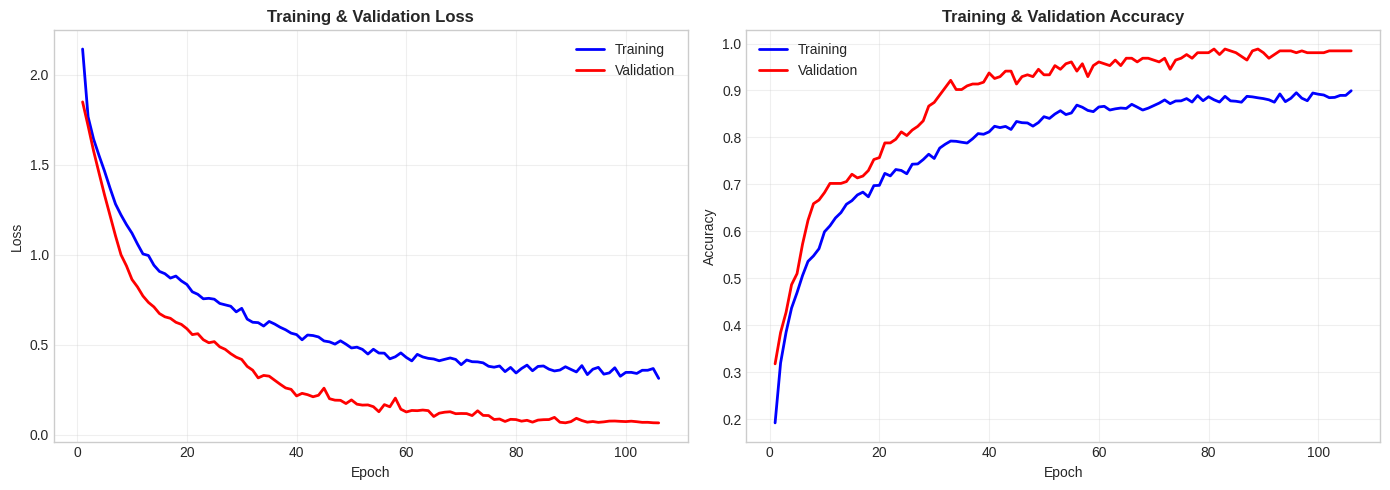

In [35]:
# =============================================================================
# 8. MODEL TRAINING
# =============================================================================
print("\n" + "=" * 70)
print("MODEL TRAINING")
print("=" * 70)

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=CONFIG['early_stop_patience'],
        restore_best_weights=True,
        mode='max',
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=CONFIG['lr_reduce_patience'],
        min_lr=1e-6,
        mode='max',
        verbose=1
    )
]

history = model.fit(
    X_train_balanced, y_train_balanced,
    validation_data=(X_val_scaled, y_val),
    epochs=CONFIG['epochs'],
    batch_size=CONFIG['batch_size'],
    callbacks=callbacks,
    verbose=1
)

print(f"\nTraining completed.")
print(f"Best validation accuracy: {max(history.history['val_accuracy']):.4f}")

# Training history visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

epochs_range = range(1, len(history.history['loss']) + 1)

axes[0].plot(epochs_range, history.history['loss'], 'b-', linewidth=2, label='Training')
axes[0].plot(epochs_range, history.history['val_loss'], 'r-', linewidth=2, label='Validation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training & Validation Loss', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(epochs_range, history.history['accuracy'], 'b-', linewidth=2, label='Training')
axes[1].plot(epochs_range, history.history['val_accuracy'], 'r-', linewidth=2, label='Validation')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training & Validation Accuracy', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('06_training_history.png', dpi=150, bbox_inches='tight')
plt.show()



MODEL EVALUATION

Validation Results:
  Loss:     0.0747
  Accuracy: 0.9882 (98.82%)

Test Results:
  Loss:     0.1224
  Accuracy: 0.9624 (96.24%)

Classification Report:
----------------------------------------------------------------------
                       precision    recall  f1-score   support

              healthy       0.98      0.95      0.97       149
  nitrogen_deficiency       0.98      0.99      0.98        86
     ph_stress_acidic       0.89      0.77      0.83        22
   ph_stress_alkaline       0.93      1.00      0.96        25
phosphorus_deficiency       1.00      0.98      0.99        65
 potassium_deficiency       0.96      1.00      0.98        51
         water_stress       0.83      0.93      0.88        27

             accuracy                           0.96       425
            macro avg       0.94      0.95      0.94       425
         weighted avg       0.96      0.96      0.96       425

Per-Class Performance:
--------------------------------------

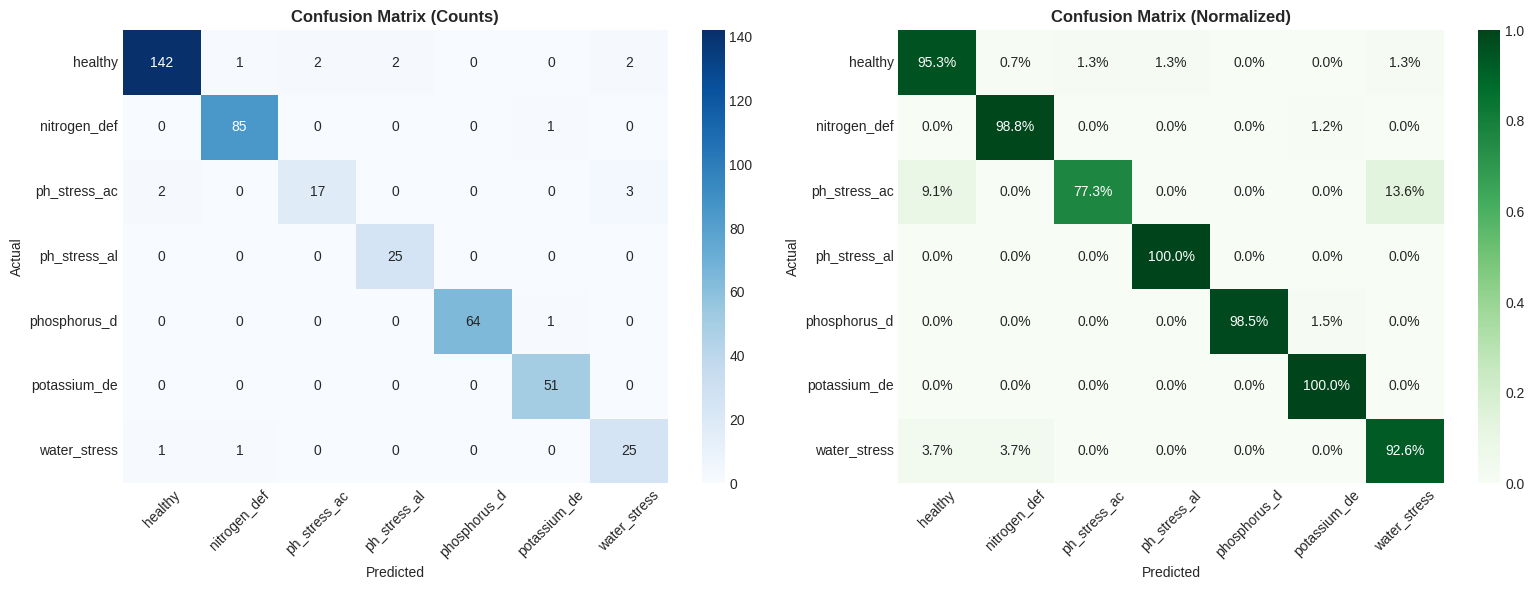

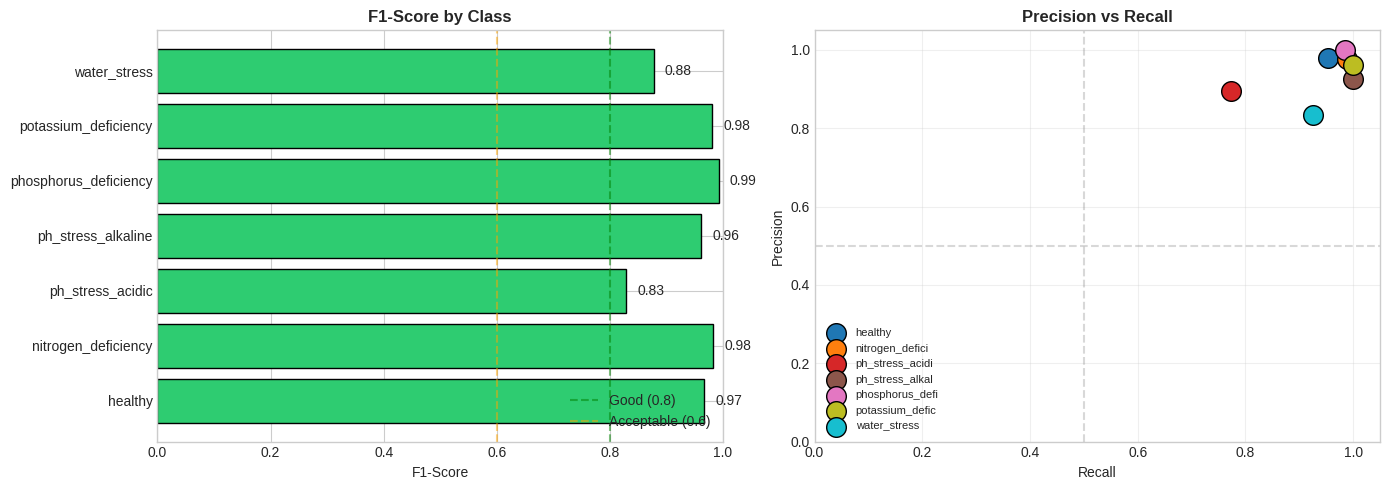

In [36]:
# =============================================================================
# 9. MODEL EVALUATION
# =============================================================================
print("\n" + "=" * 70)
print("MODEL EVALUATION")
print("=" * 70)

# Evaluate on validation set
val_loss, val_accuracy = model.evaluate(X_val_scaled, y_val, verbose=0)
print(f"\nValidation Results:")
print(f"  Loss:     {val_loss:.4f}")
print(f"  Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"\nTest Results:")
print(f"  Loss:     {test_loss:.4f}")
print(f"  Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Predictions
y_pred = np.argmax(model.predict(X_test_scaled, verbose=0), axis=1)

# Classification report
print(f"\nClassification Report:")
print("-" * 70)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred)

print("Per-Class Performance:")
print("-" * 70)
print(f"{'Class':<25} {'Precision':>10} {'Recall':>10} {'F1-Score':>10} {'Support':>10}")
print("-" * 70)
for i, cls in enumerate(label_encoder.classes_):
    status = "GOOD" if recall[i] >= 0.7 else "OK" if recall[i] >= 0.5 else "LOW"
    print(f"{cls:<25} {precision[i]:>10.3f} {recall[i]:>10.3f} {f1[i]:>10.3f} {support[i]:>10} [{status}]")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[c[:12] for c in label_encoder.classes_],
            yticklabels=[c[:12] for c in label_encoder.classes_], ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix (Counts)', fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)

sns.heatmap(cm_normalized, annot=True, fmt='.1%', cmap='Greens',
            xticklabels=[c[:12] for c in label_encoder.classes_],
            yticklabels=[c[:12] for c in label_encoder.classes_], ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Confusion Matrix (Normalized)', fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('07_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Performance metrics visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors_f1 = ['#2ecc71' if f >= 0.8 else '#f39c12' if f >= 0.6 else '#e74c3c' for f in f1]
axes[0].barh(label_encoder.classes_, f1, color=colors_f1, edgecolor='black')
axes[0].set_xlabel('F1-Score')
axes[0].set_title('F1-Score by Class', fontweight='bold')
axes[0].axvline(x=0.8, color='green', linestyle='--', alpha=0.5, label='Good (0.8)')
axes[0].axvline(x=0.6, color='orange', linestyle='--', alpha=0.5, label='Acceptable (0.6)')
axes[0].set_xlim(0, 1.0)
axes[0].legend(loc='lower right')
for i, (bar, score) in enumerate(zip(axes[0].patches, f1)):
    axes[0].text(score + 0.02, bar.get_y() + bar.get_height()/2, f'{score:.2f}', va='center')

colors_scatter = plt.cm.tab10(np.linspace(0, 1, n_classes))
for i, cls in enumerate(label_encoder.classes_):
    axes[1].scatter(recall[i], precision[i], s=200, c=[colors_scatter[i]],
                    label=cls[:15], edgecolors='black', linewidth=1)
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision vs Recall', fontweight='bold')
axes[1].set_xlim(0, 1.05)
axes[1].set_ylim(0, 1.05)
axes[1].axhline(y=0.5, color='gray', linestyle='--', alpha=0.3)
axes[1].axvline(x=0.5, color='gray', linestyle='--', alpha=0.3)
axes[1].legend(loc='lower left', fontsize=8)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('08_performance_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

In [37]:
# =============================================================================
# 10. MODEL CONVERSION (TensorFlow Lite)
# =============================================================================
print("\n" + "=" * 70)
print("MODEL CONVERSION (TensorFlow Lite INT8)")
print("=" * 70)

def representative_dataset():
    for i in range(min(500, len(X_train_scaled))):
        yield [X_train_scaled[i:i+1].astype(np.float32)]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

print("\nConverting model to TensorFlow Lite (INT8)...")
tflite_model = converter.convert()

tflite_size_bytes = len(tflite_model)
tflite_size_kb = tflite_size_bytes / 1024

with open(CONFIG['model_filename'], 'wb') as f:
    f.write(tflite_model)

print(f"\nConversion complete.")
print(f"  Model size: {tflite_size_bytes:,} bytes ({tflite_size_kb:.2f} KB)")
print(f"  Target limit: 20 KB")
print(f"  Status: {'PASS' if tflite_size_kb < 20 else 'FAIL'}")




MODEL CONVERSION (TensorFlow Lite INT8)

Converting model to TensorFlow Lite (INT8)...
Saved artifact at '/tmp/tmpls49zjzs'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 6), dtype=tf.float32, name='input')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  137432190410128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137434765529488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137434765529296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137431696390096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137431696389520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137432313135760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137431696390672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137431696386832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137431613164816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1374316131680

In [38]:
# =============================================================================
# 11. TFLITE MODEL VALIDATION
# =============================================================================
print("\n" + "=" * 70)
print("TFLITE MODEL VALIDATION")
print("=" * 70)

interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_scale, input_zero_point = input_details[0]['quantization']
output_scale, output_zero_point = output_details[0]['quantization']

print(f"\nModel specifications:")
print(f"  Input shape:      {input_details[0]['shape']}")
print(f"  Input dtype:      {input_details[0]['dtype']}")
print(f"  Input scale:      {input_scale}")
print(f"  Input zero point: {input_zero_point}")
print(f"  Output shape:     {output_details[0]['shape']}")
print(f"  Output dtype:     {output_details[0]['dtype']}")
print(f"  Output scale:     {output_scale}")
print(f"  Output zero point: {output_zero_point}")

# Validate TFLite accuracy
print(f"\nValidating TFLite model on test set...")
correct = 0
for i in range(len(X_test_scaled)):
    input_data = X_test_scaled[i:i+1].astype(np.float32)
    input_quantized = (input_data / input_scale + input_zero_point).astype(np.int8)

    interpreter.set_tensor(input_details[0]['index'], input_quantized)
    interpreter.invoke()

    output = interpreter.get_tensor(output_details[0]['index'])
    if np.argmax(output) == y_test[i]:
        correct += 1

tflite_accuracy = correct / len(X_test_scaled)
accuracy_drop = (test_accuracy - tflite_accuracy) * 100

print(f"\nAccuracy comparison:")
print(f"  Keras model:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"  TFLite model: {tflite_accuracy:.4f} ({tflite_accuracy*100:.2f}%)")
print(f"  Accuracy drop: {accuracy_drop:.2f}%")
print(f"  Status: {'EXCELLENT' if accuracy_drop < 1 else 'GOOD' if accuracy_drop < 3 else 'ACCEPTABLE' if accuracy_drop < 5 else 'REVIEW'}")



TFLITE MODEL VALIDATION

Model specifications:
  Input shape:      [1 6]
  Input dtype:      <class 'numpy.int8'>
  Input scale:      0.03180038556456566
  Input zero point: -11
  Output shape:     [1 7]
  Output dtype:     <class 'numpy.int8'>
  Output scale:     0.00390625
  Output zero point: -128

Validating TFLite model on test set...

Accuracy comparison:
  Keras model:  0.9624 (96.24%)
  TFLite model: 0.9224 (92.24%)
  Accuracy drop: 4.00%
  Status: ACCEPTABLE


In [39]:
# =============================================================================
# 12. GENERATE DEPLOYMENT CODE
# =============================================================================
print("\n" + "=" * 70)
print("GENERATING DEPLOYMENT CODE")
print("=" * 70)

def convert_to_c_array(data, var_name):
    hex_vals = [f"0x{b:02x}" for b in data]
    lines = [", ".join(hex_vals[i:i+12]) for i in range(0, len(hex_vals), 12)]
    return f"const unsigned char {var_name}[] PROGMEM = {{\n  " + ",\n  ".join(lines) + f"\n}};\nconst unsigned int {var_name}_len = {len(data)};\n"

# Generate header file
header_content = f"""// ============================================================================
// PLANT HEALTH CLASSIFICATION MODEL
// TinyML Model for ESP32 Deployment
// Generated automatically - Do not edit manually
// ============================================================================

#ifndef PLANT_HEALTH_MODEL_H
#define PLANT_HEALTH_MODEL_H

// Model configuration
#define NUM_FEATURES {n_features}
#define NUM_CLASSES {n_classes}

// Class labels
const char* CLASS_LABELS[NUM_CLASSES] = {{
{chr(10).join([f'    "{label}",' for label in label_encoder.classes_])}
}};

// Feature names (for reference)
// {', '.join(CONFIG['features'])}

// Normalization parameters (StandardScaler)
const float FEATURE_MEANS[NUM_FEATURES] = {{{', '.join([f'{m:.6f}f' for m in scaler.mean_])}}};
const float FEATURE_STDS[NUM_FEATURES] = {{{', '.join([f'{s:.6f}f' for s in scaler.scale_])}}};

// Quantization parameters
const float INPUT_SCALE = {input_scale}f;
const int8_t INPUT_ZERO_POINT = {input_zero_point};
const float OUTPUT_SCALE = {output_scale}f;
const int8_t OUTPUT_ZERO_POINT = {output_zero_point};

// Model data
{convert_to_c_array(tflite_model, 'MODEL_DATA')}

#endif // PLANT_HEALTH_MODEL_H
"""

with open(CONFIG['header_filename'], 'w') as f:
    f.write(header_content)

print(f"Generated: {CONFIG['header_filename']}")

# Print deployment parameters
print("\n" + "=" * 70)
print("DEPLOYMENT PARAMETERS")
print("=" * 70)
print(f"""
// Copy these parameters to your embedded application

#define NUM_FEATURES {n_features}
#define NUM_CLASSES {n_classes}

const char* CLASS_LABELS[] = {{
{chr(10).join([f'    "{label}",' for label in label_encoder.classes_])}
}};

const float FEATURE_MEANS[] = {{{', '.join([f'{m:.6f}f' for m in scaler.mean_])}}};
const float FEATURE_STDS[] = {{{', '.join([f'{s:.6f}f' for s in scaler.scale_])}}};

const float INPUT_SCALE = {input_scale}f;
const int8_t INPUT_ZERO_POINT = {input_zero_point};
const float OUTPUT_SCALE = {output_scale}f;
const int8_t OUTPUT_ZERO_POINT = {output_zero_point};
""")



GENERATING DEPLOYMENT CODE
Generated: plant_health_model.h

DEPLOYMENT PARAMETERS

// Copy these parameters to your embedded application

#define NUM_FEATURES 6
#define NUM_CLASSES 7

const char* CLASS_LABELS[] = {
    "healthy",
    "nitrogen_deficiency",
    "ph_stress_acidic",
    "ph_stress_alkaline",
    "phosphorus_deficiency",
    "potassium_deficiency",
    "water_stress",
};

const float FEATURE_MEANS[] = {50.707554f, 51.891892f, 45.049896f, 6.467726f, 45.619543f, 25.445010f};
const float FEATURE_STDS[] = {37.324601f, 31.497452f, 46.560942f, 0.790436f, 26.087041f, 5.796667f};

const float INPUT_SCALE = 0.03180038556456566f;
const int8_t INPUT_ZERO_POINT = -11;
const float OUTPUT_SCALE = 0.00390625f;
const int8_t OUTPUT_ZERO_POINT = -128;



In [44]:
# =============================================================================
# 13. SUMMARY
# =============================================================================
print("\n" + "=" * 70)
print("TRAINING COMPLETE - SUMMARY")
print("=" * 70)
print(f"""
MODEL INFORMATION
  Architecture:     Dense(24) -> Dense(16) -> Dense(12) -> Dense({n_classes})
  Parameters:       {model.count_params():,}
  Input features:   {n_features}
  Output classes:   {n_classes}

PERFORMANCE METRICS
  Test accuracy:    {test_accuracy*100:.2f}%
  TFLite accuracy:  {tflite_accuracy*100:.2f}%
  Accuracy drop:    {accuracy_drop:.2f}%
  Macro F1-score:   {np.mean(f1):.3f}

DEPLOYMENT
  Model format:     TensorFlow Lite (INT8 quantized)
  Model size:       {tflite_size_kb:.2f} KB
  Target platform:  ESP32 / Embedded systems

OUTPUT FILES
  {CONFIG['model_filename']}
  {CONFIG['header_filename']}
  {CONFIG['package_filename']}

CLASS MAPPING
{chr(10).join([f'  {i} -> {cls}' for i, cls in enumerate(label_encoder.classes_)])}
""")

# Download package
print("\nStarting download...")
files.download(CONFIG['package_filename'])



TRAINING COMPLETE - SUMMARY

MODEL INFORMATION
  Architecture:     Dense(24) -> Dense(16) -> Dense(12) -> Dense(7)
  Parameters:       1,023
  Input features:   6
  Output classes:   7

PERFORMANCE METRICS
  Test accuracy:    96.24%
  TFLite accuracy:  92.24%
  Accuracy drop:    4.00%
  Macro F1-score:   0.941

DEPLOYMENT
  Model format:     TensorFlow Lite (INT8 quantized)
  Model size:       5.52 KB
  Target platform:  ESP32 / Embedded systems

OUTPUT FILES
  plant_health_model.tflite
  plant_health_model.h
  plant_health_model_package.zip

CLASS MAPPING
  0 -> healthy
  1 -> nitrogen_deficiency
  2 -> ph_stress_acidic
  3 -> ph_stress_alkaline
  4 -> phosphorus_deficiency
  5 -> potassium_deficiency
  6 -> water_stress


Starting download...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>